# Designing a power divider for wireless communications part 2: Adding harmonic suppression

The power divider is a key component in modern wireless communications systems. It is usually subject to key performance metrics such as low insertion loss, minimal crosstalk between output ports, and a small footprint. In addition, low pass or bandpass filters are typically incorporated in order to suppress unwanted harmonics and noise in wireless signals. These filters should have a sharp response, quantified by the roll-off rate (ROR), and a wide stopband. 

In this 3-part notebook series, we will simulate various stages of the design process of a Wilkinson power divider (WPD) created by Moloudian et al in [1]. 
* In [part one](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression1/), we started with a simple low pass filter design and improved its filter response in order to achieve a higher roll-off rate (ROR).
* In part two (this notebook), we will add a harmonic suppression circuit to the low pass filter to achieve a wide stopband.
* In [part three](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression3/), we will implement the full WPD design and compare its performance to a conventional WPD. 

<center><img src="./img/wpdhs_2_render.png" width=520 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.rf as rf
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging.level = "ERROR"

## General Parameters and Mediums

The bandwidth of the simulation is defined below. We set a relatively wide range (0.1-16 GHz) to examine the stopband behavior. 

In [2]:
(f_min, f_max) = (0.1e9, 16e9)
bandwidth = td.FreqRange.from_freq_interval(f_min, f_max)
f0 = bandwidth.freq0
freqs = bandwidth.freqs(num_points=601)

The substrate is FR4 and the metallic traces are copper. We assume both materials have constant non-zero loss across the bandwidth: loss tangent of 0.022 for FR4 and conductivity of 6E7 S/m (i.e. 60 S/um) for copper. 

In [3]:
med_FR4 = FastDispersionFitter.constant_loss_tangent_model(4.4, 0.022, (f_min, f_max))
med_Cu = rf.LossyMetalMedium(conductivity=60, frequency_range=(f_min, f_max))

Output()

## Modified Low-pass Filter

For more information on the design of the modified low pass filter, please refer to the [first notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression1/) in this series.

### Structure

The dimensions of the modified low-pass filter is obtained from [1]. Some dimensions are missing and are estimated visually. 

In [4]:
# Geometry dimensions
mm = 1000  # Conversion mm to micron
H = 0.8 * mm  # Substrate thickness
T = 0.035 * mm  # Metal thickness

# Resonator dimensions
MA, MB, MC, MD = (3.9 * mm, 7.1 * mm, 3.1 * mm, 2.3 * mm)
ME, MF, MG, MH = (0.6 * mm, 0.2 * mm, 1.2 * mm, 0.5 * mm)
MJ, MK, MM, MN = (4.8 * mm, 0.3 * mm, 0.1 * mm, 0.7 * mm)
MP, MQ, MR, MS = (0.1 * mm, 0.7 * mm, 0.4 * mm, 0.3 * mm)
Lsub, Wsub = (2 * MC + MH, 2 * (MH + MK + MB))

In [5]:
# Resonator geometry
geom_patch = td.Box.from_bounds(rmin=(-MA / 2, MH / 2 + MK, 0), rmax=(MA / 2, MH / 2 + MK + MB, T))
geom_hole1 = td.Box.from_bounds(
    rmin=(-MH / 2 - MN - MF - ME, MH / 2 + MK + MS, 0),
    rmax=(-MH / 2 - MN - MF, MH / 2 + MK + MS + MG, T),
)
geom_hole2 = geom_hole1.translated(2 * (MF + MN) + MH + ME, 0, 0)
geom_hole3 = td.Cylinder(center=(0, MH / 2 + MD + MQ, T / 2), radius=MR, length=T, axis=2)
geom_hole4 = geom_hole3.translated(0, MQ + 2 * MR, 0)
geom_hole5 = td.Box.from_bounds(
    rmin=(-MA / 2 + 1.5 * MF, MH / 2 + MK + MS + MG + MQ, 0),
    rmax=(-MA / 2 + 1.5 * MF + MM, MH / 2 + MK + MB - MP, T),
)
geom_hole6 = geom_hole5.translated(-2 * geom_hole5.center[0], 0, 0)
geom_hole7 = td.Box.from_bounds(
    rmin=(-MH / 2 - MN, MH / 2 + MK, 0), rmax=(MH / 2 + MN, MH / 2 + MD, T)
)
for hole in [geom_hole1, geom_hole2, geom_hole3, geom_hole4, geom_hole5, geom_hole6, geom_hole7]:
    geom_patch -= hole

geom_line1 = td.Box.from_bounds(rmin=(-MH / 2, MH / 2, 0), rmax=(MH / 2, MH / 2 + MD, T))
geom_resonator_modified = td.GeometryGroup(geometries=[geom_line1, geom_patch])
geom_feedline = td.Box.from_bounds(rmin=(-MH / 2 - MC, -MH / 2, 0), rmax=(MH / 2 + MC, MH / 2, T))

# Substrate and ground
x0, y0, z0 = geom_resonator_modified.bounding_box.center
geom_sub = td.Box(center=(x0, y0, -H / 2), size=(Lsub, Wsub, H))
geom_gnd = td.Box(center=(x0, y0, -H - T / 2), size=(Lsub, Wsub, T))

# Structures
str_resonator_modified = td.Structure(geometry=geom_resonator_modified, medium=med_Cu)
str_feedline = td.Structure(geometry=geom_feedline, medium=med_Cu)
str_sub = td.Structure(geometry=geom_sub, medium=med_FR4)
str_gnd = td.Structure(geometry=geom_gnd, medium=med_Cu)
str_list_modified = [str_sub, str_gnd, str_feedline, str_resonator_modified]

### Monitors and Ports

We define an in-plane field monitor for visualization purposes. 

In [6]:
# Field Monitors
mon_1 = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[f_min, f0, f_max],
    name="field in-plane",
)

The feedline is terminated by two 50 ohm lumped ports. 

In [7]:
# Lumped port
lp_options = {"size": (0, MH, H), "voltage_axis": 2, "impedance": 50}
LP1 = rf.LumpedPort(center=(-MH / 2 - MC, 0, -H / 2), name="LP1", **lp_options)
LP2 = rf.LumpedPort(center=(MH / 2 + MC, 0, -H / 2), name="LP2", **lp_options)
port_list = [LP1, LP2]  # List of ports

### Grid and Boundary

By default, the simulation boundary is open (PML) on all sides. We add wavelength/4 padding on all sides to ensure the boundaries do not encroach on the near-field. 

In [8]:
# Add padding
padding = td.C_0 / f0 / 2
sim_LX = Lsub + padding
sim_LY = Wsub + padding
sim_LZ = H + padding

We use `LayerRefinementSpec` to automatically refine the grid along corners and edges of the metallic traces. The rest of the grid is automatically created with the minimum grid size determined by the wavelength. 

In [9]:
# Layer refinement on resonator
lr_spec = rf.LayerRefinementSpec.from_structures(
    structures=[str_resonator_modified, str_feedline],
    min_steps_along_axis=1,
    corner_refinement=td.GridRefinement(dl=T, num_cells=2),
)

# Define overall grid spec
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f0,
    min_steps_per_wvl=12,
    layer_refinement_specs=[lr_spec],
)

### Define Simulation and TerminalComponentModeler

We define the `Simulation` and `TerminalComponentModeler` objects below. The latter facilitates a batch port sweep in order to compute the full S-parameter matrix. 

In [10]:
# Define simulation object
sim = td.Simulation(
    center=(x0, y0, z0),
    size=(sim_LX, sim_LY, sim_LZ),
    structures=str_list_modified,
    grid_spec=grid_spec,
    monitors=[mon_1],
    run_time=6e-9,
    plot_length_units="mm",
)

In [11]:
# Define TerminalComponentModeler
tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
    remove_dc_component=False,
)

### Visualization

The structure layout and simulation grid are visualized below. 

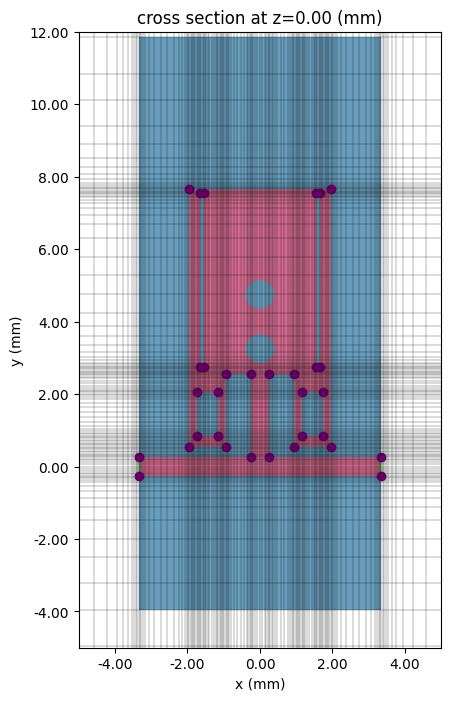

In [12]:
# In-plane
fig, ax = plt.subplots(figsize=(8, 8))
tcm.plot_sim(z=0, ax=ax, monitor_alpha=0)
tcm.simulation.plot_grid(z=0, ax=ax, hlim=(-5 * mm, 5 * mm), vlim=(-5 * mm, 12 * mm))
plt.show()

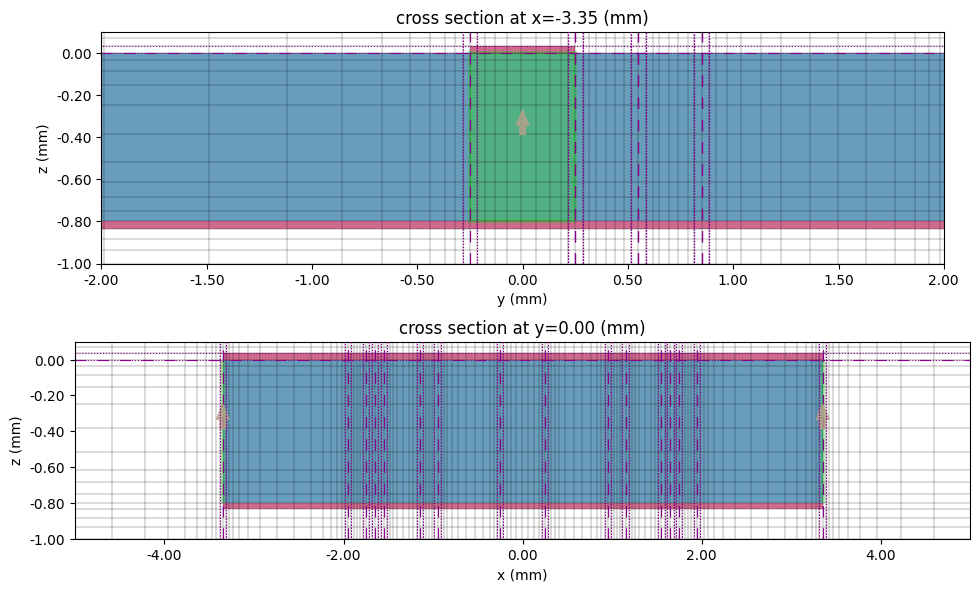

In [13]:
# Cross section and port
fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
tcm.plot_sim(x=-MH / 2 - MC, ax=ax[0], monitor_alpha=0)
tcm.simulation.plot_grid(x=-MH / 2 - MC, ax=ax[0], hlim=(-2 * mm, 2 * mm), vlim=(-1 * mm, 0.1 * mm))
tcm.plot_sim(y=0, ax=ax[1], monitor_alpha=0)
tcm.simulation.plot_grid(y=0, ax=ax[1], hlim=(-5 * mm, 5 * mm), vlim=(-1 * mm, 0.1 * mm))
ax[1].set_aspect(2)
plt.show()

### Running the Simulation

In [14]:
tcm_data_modified = td.web.run(
    tcm, task_name="WPD modified resonator", path="data/tcm_data_modified.hdf5"
)

16:43:19 EST Created task 'WPD modified resonator' with resource_id             
             'sid-bb2b3aed-5263-42bb-b865-42114a0b768d' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=930261;https://tidy3d.simulation.cloud/rf?taskId=pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=546924;https://tidy3d.simulation.cloud/rf?taskId=pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae\taskId]8;;\]8;id=930261;https://tidy3d.simulation.cloud/rf?taskId=pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae\=]8;;\]8;id=474309;https://tidy3d.simulation.cloud/rf?taskId=pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae\pa]8;;\]8;id=930261;https://tidy3d.simulation.cloud/rf?taskId=pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae\-cae4f21d-7e58-4cd6-a9]8;;\
             ]8;id=930261;https://tidy3d.simulation.cloud/rf?taskId=pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae\c7-b456fe3301ae']8;;\.

             Task folder: ]8;id=555461;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

16:43:27 EST Maximum FlexCredit cost: 0.244. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

16:43:28 EST Subtasks status - WPD modified resonator                           
             Group ID: 'pa-cae4f21d-7e58-4cd6-a9c7-b456fe3301ae'

Output()

             Batch status = preprocess

16:43:34 EST Batch status = running

16:44:34 EST Batch status = postprocess

16:44:47 EST Modeler has finished running successfully.

             Billed flex credit cost: 0.107.

Output()

16:44:49 EST Loading component modeler data from data/tcm_data_modified.hdf5

### Results

#### Field Profile

The simulation monitor data is stored as `dict` values in the `data` attribute of the `TerminalComponentModelerData` instance. Use the port name as the key to access the data associated with the respective port excitation. 

In [15]:
sim_data = tcm_data_modified.data["LP1"]

The field amplitude profiles at the minimum and middle frequency points are shown below. The points lie respectively within the pass- and stopbands. 

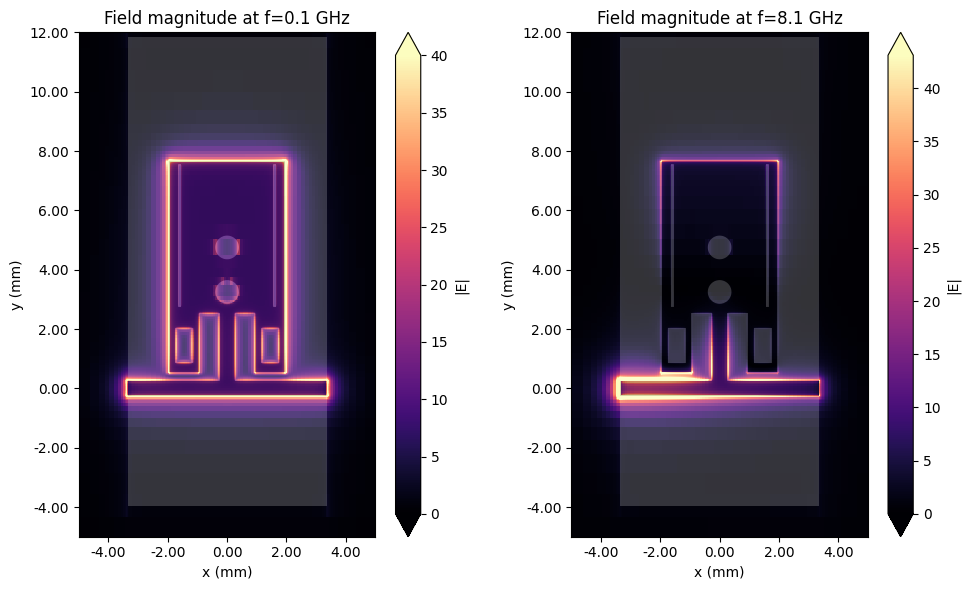

In [16]:
# Field plots
fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
sim_data.plot_field("field in-plane", "E", val="abs", f=f_min, ax=ax[0])
ax[0].set_title(f"Field magnitude at f={f_min / 1e9:.1f} GHz")
sim_data.plot_field("field in-plane", "E", val="abs", f=f0, ax=ax[1])
ax[1].set_title(f"Field magnitude at f={f0 / 1e9:.1f} GHz")
for axis in ax:
    axis.set_xlim(-5 * mm, 5 * mm)
    axis.set_ylim(-5 * mm, 12 * mm)
plt.show()

#### S-parameters

We use the `port_in` and `port_out` coordinates to access the specific S-parameter from the full matrix. Note the use of `np.conjugate()` to convert from the default physics phase convention to the engineering convention. 

In [17]:
smat = tcm_data_modified.smatrix()
S11 = np.conjugate(smat.data.isel(port_in=0, port_out=0))
S21 = np.conjugate(smat.data.isel(port_in=0, port_out=1))
S11dB = 20 * np.log10(np.abs(S11))
S21dB = 20 * np.log10(np.abs(S21))

The insertion and return losses are plotted below. While the modified filter presents a sharp rolloff and a deep resonance above 2 GHz, the signal suppression is less than ideal at higher frequencies (>5 GHz). 

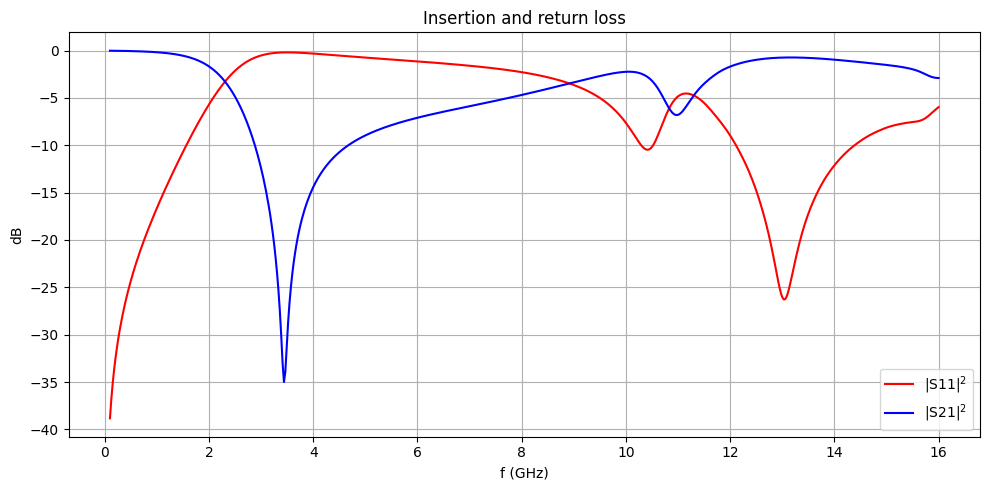

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs / 1e9, S11dB, "r", label="|S11|$^2$")
ax.plot(freqs / 1e9, S21dB, "b", label="|S21|$^2$")
ax.set_title("Insertion and return loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

## Harmonic Suppression Structure

In order to widen the stopband of the resonator, we introduce a harmonic suppression structure. The structure consists of a kinked feedline and five side resonator patches. The equivalent circuit is shown below. 

<center><img src="./img/wpdhs_2_schematic.png" width=600 /></center>

The figure above is taken from Figure 4 in [1].  

### Structure

The geometry dimensions, where available, are taken from [1]. Some dimensions are missing and are instead estimated visually.

In [19]:
# Suppression structure dimensions
SA, SB, SC, SD = (3 * mm, 11.3 * mm, 4.4 * mm, 6.5 * mm)
SE, SF, SG, SH = (2.7 * mm, 1 * mm, 1.7 * mm, 3.7 * mm)
SK, SL, SM, SN = (0.5 * mm, 1 * mm, 0.5 * mm, 4.6 * mm)
SP, SQ, SR, SS, ST = (0.8 * mm, 1.5 * mm, 2 * mm, 5.9 * mm, 4.6 * mm)
Lsub2, Wsub2 = (SB + 2 * SC, 2 * (SK + 2 * (SP + ST)))

In [20]:
# Side patches
def create_side_patch(x0, y0):
    """create side patch geometry with feed input centered at (x0, y0)"""
    patch_vertices = [x0, y0] + np.array(
        [
            [SK / 2, 0],
            [SK / 2, SP],
            [SA / 2, SP],
            [SA / 2, SP + ST],
            [-SA / 2, SP + ST],
            [-SA / 2, SP],
            [-SK / 2, SP],
            [-SK / 2, 0],
        ]
    )
    patch_geom = td.PolySlab(vertices=patch_vertices, axis=2, slab_bounds=(0, T))
    return patch_geom


geom_patch1 = create_side_patch(-(SB + SA) / 2, SK / 2)
geom_patch2 = geom_patch1.reflected((0, -1, 0)).translated(0, 0.3 * mm, 0)
geom_patch3 = geom_patch1.reflected((1, 0, 0))
geom_patch4 = geom_patch3.reflected((0, -1, 0)).translated(0, 0.3 * mm, 0)

# Bent feedline
half_bfl_vertices = np.array(
    [
        [-SD / 2, SK / 2],
        [-SD / 2, -SR / 2 + SK / 2],
        [-SD / 2 - SM, -SR / 2 + SK / 2],
        [-SD / 2 - SM, (SR + SK) / 2],
        [-SD / 2 - SM - SQ, (SR + SK) / 2],
        [-SD / 2 - SM - SQ, SK / 2],
        [-SB / 2 - SC, SK / 2],
        [-SB / 2 - SC, -SK / 2],
        [-SD / 2 - SM - SQ + SK, -SK / 2],
        [-SD / 2 - SM - SQ + SK, SR / 2 - SK / 2],
        [-SD / 2 - SM - SK, SR / 2 - SK / 2],
        [-SD / 2 - SM - SK, -(SR + SK) / 2],
        [-SD / 2 + SK, -(SR + SK) / 2],
        [-SD / 2 + SK, -SK / 2],
    ]
)
bfl_vertices = np.append(half_bfl_vertices, np.flip(half_bfl_vertices * [-1, 1], axis=0), axis=0)
geom_bend_feedline = td.PolySlab(vertices=bfl_vertices, axis=2, slab_bounds=(0, T))

# Bottom middle resonator
bmres_vertices = np.array(
    [
        [-SK / 2, -SK / 2],
        [-SK / 2, -SK / 2 - SN],
        [-SK / 2 - SF, -SK / 2 - SN],
        [-SK / 2 - SF, -SK / 2 - SN - SK + SH],
        [-SS / 2, -SK / 2 - SN - SK + SH],
        [-SS / 2, -SK / 2 - SN - SK],
        [SS / 2, -SK / 2 - SN - SK],
        [SS / 2, -SK / 2 - SN - SK + SH],
        [SK / 2 + SF, -SK / 2 - SN - SK + SH],
        [SK / 2 + SF, -SK / 2 - SN],
        [SK / 2, -SK / 2 - SN],
        [SK / 2, -SK / 2],
    ]
)
geom_bottom_resonator = td.PolySlab(vertices=bmres_vertices, axis=2, slab_bounds=(0, T))

# Group all harmonic suppression geometry objects
geom_harmonic_suppression = td.GeometryGroup(
    geometries=[
        geom_patch1,
        geom_patch2,
        geom_patch3,
        geom_patch4,
        geom_bend_feedline,
        geom_bottom_resonator,
    ]
)

In [21]:
# Create structures
str_sub2 = td.Structure(
    geometry=td.Box(center=(0, 0, -H / 2), size=(Lsub2, Wsub2, H)), medium=med_FR4
)
str_gnd2 = td.Structure(
    geometry=td.Box(center=(0, 0, -H - T / 2), size=(Lsub2, Wsub2, T)), medium=med_Cu
)
str_harmonic_suppression = td.Structure(geometry=geom_harmonic_suppression, medium=med_Cu)

str_list_harmonic_suppression = [
    str_sub2,
    str_gnd2,
    str_harmonic_suppression,
    str_resonator_modified,
]

### Monitors and Ports

We will reuse the monitor defined in the previous section. The lumped ports are shifted slightly to account for the new substrate size. 

In [22]:
# Lumped port
lp_options = {"size": (0, SK, H), "voltage_axis": 2, "impedance": 50}
LP1 = rf.LumpedPort(center=(-Lsub2 / 2, 0, -H / 2), name="LP1", **lp_options)
LP2 = rf.LumpedPort(center=(Lsub2 / 2, 0, -H / 2), name="LP2", **lp_options)
port_list = [LP1, LP2]  # List of ports

### Grid and Boundary

The boundary and grid specifications are same as before. 

In [23]:
# Add padding
padding = td.C_0 / f0 / 2
sim_LX = Lsub2 + padding
sim_LY = Wsub2 + padding
sim_LZ = H + padding

In [24]:
# Layer refinement on resonator
lr_spec = rf.LayerRefinementSpec.from_structures(
    structures=[str_resonator_modified, str_harmonic_suppression],
    min_steps_along_axis=1,
    corner_refinement=td.GridRefinement(dl=T, num_cells=2),
)

# Define overall grid spec
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f0,
    min_steps_per_wvl=12,
    layer_refinement_specs=[lr_spec],
)

### Simulation and TerminalComponentModeler

The harmonic suppression structure is highly resonant at certain frequencies. To capture its behavior down to the -70 dB level, we increased the `run_time` and reduced the `shutoff` level. If we were only interested down to -40 dB, it would be OK to cut off the simulation at a much earlier point to save on computational cost. 

In [25]:
# Define simulation object
sim = td.Simulation(
    center=(0, 0, 0),
    size=(sim_LX, sim_LY, sim_LZ),
    structures=str_list_harmonic_suppression,
    grid_spec=grid_spec,
    monitors=[mon_1],
    run_time=40e-9,
    shutoff=1e-6,
    plot_length_units="mm",
)

In [26]:
# Define TerminalComponentModeler
tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
    remove_dc_component=False,
)

### Visualization

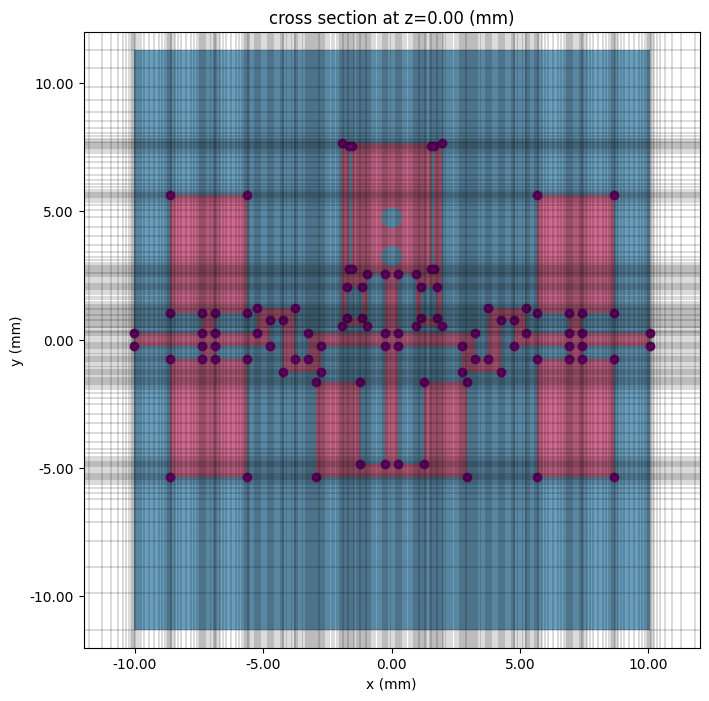

In [27]:
# In-plane
fig, ax = plt.subplots(figsize=(8, 8))
tcm.plot_sim(z=0, ax=ax, monitor_alpha=0)
tcm.simulation.plot_grid(z=0, ax=ax, hlim=(-12 * mm, 12 * mm), vlim=(-12 * mm, 12 * mm))
plt.show()

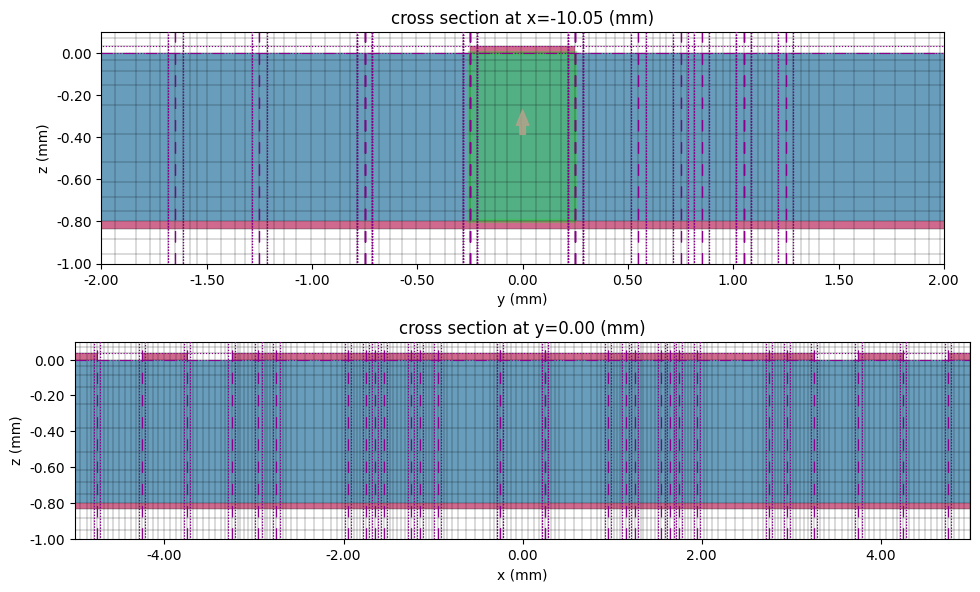

In [28]:
# Cross section
fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
tcm.plot_sim(x=-Lsub2 / 2, ax=ax[0], monitor_alpha=0)
tcm.simulation.plot_grid(x=-Lsub2 / 2, ax=ax[0], hlim=(-2 * mm, 2 * mm), vlim=(-1 * mm, 0.1 * mm))
tcm.plot_sim(y=0, ax=ax[1], monitor_alpha=0)
tcm.simulation.plot_grid(y=0, ax=ax[1], hlim=(-5 * mm, 5 * mm), vlim=(-1 * mm, 0.1 * mm))
ax[1].set_aspect(2)
plt.show()

### Running the Simulation

In [29]:
tcm_data_hs = td.web.run(tcm, task_name="WPD harmonic suppression", path="data/tcm_data_hs.hdf5")

16:44:53 EST Created task 'WPD harmonic suppression' with resource_id           
             'sid-293f558e-803c-45fe-a05c-a7bf46856bf4' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=986695;https://tidy3d.simulation.cloud/rf?taskId=pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=736480;https://tidy3d.simulation.cloud/rf?taskId=pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8\taskId]8;;\]8;id=986695;https://tidy3d.simulation.cloud/rf?taskId=pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8\=]8;;\]8;id=80138;https://tidy3d.simulation.cloud/rf?taskId=pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8\pa]8;;\]8;id=986695;https://tidy3d.simulation.cloud/rf?taskId=pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8\-191d94e8-bce5-472c-b1]8;;\
             ]8;id=986695;https://tidy3d.simulation.cloud/rf?taskId=pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8\53-cb7a2ebb81f8']8;;\.

             Task folder: ]8;id=988525;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

16:45:00 EST Maximum FlexCredit cost: 6.396. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

16:45:01 EST Subtasks status - WPD harmonic suppression                         
             Group ID: 'pa-191d94e8-bce5-472c-b153-cb7a2ebb81f8'

Output()

             Batch status = preprocess

16:45:07 EST Batch status = running

16:50:46 EST Batch status = postprocess

16:51:03 EST Modeler has finished running successfully.

16:51:04 EST Billed flex credit cost: 4.606.

Output()

16:51:06 EST Loading component modeler data from data/tcm_data_hs.hdf5

### Results

#### Field Profile

In [30]:
sim_data2 = tcm_data_hs.data["LP1"]

As before, we plot the field amplitude profile at the minimum and middle frequency points, showing the difference between passband and stopband behavior. 

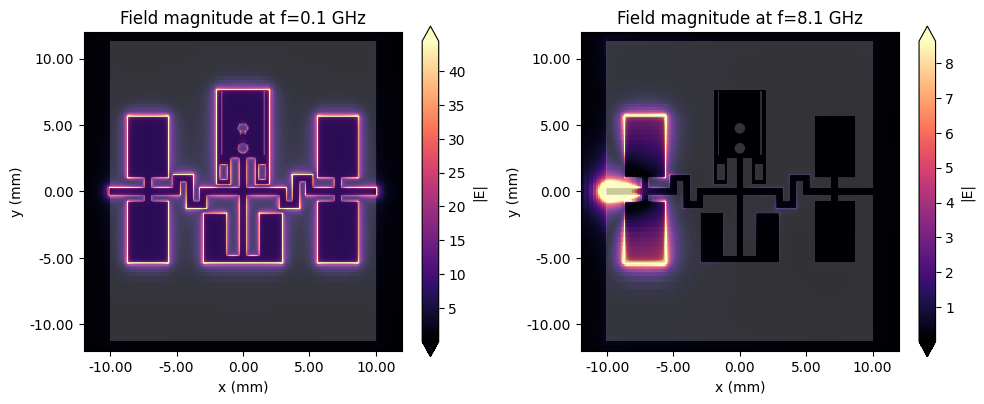

In [31]:
# Field plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
sim_data2.plot_field("field in-plane", "E", val="abs", f=f_min, ax=ax[0])
ax[0].set_title(f"Field magnitude at f={f_min / 1e9:.1f} GHz")
sim_data2.plot_field("field in-plane", "E", val="abs", f=f0, ax=ax[1])
ax[1].set_title(f"Field magnitude at f={f0 / 1e9:.1f} GHz")
for axis in ax:
    axis.set_xlim(-12 * mm, 12 * mm)
    axis.set_ylim(-12 * mm, 12 * mm)
plt.show()

#### S-parameters

In [32]:
smat2 = tcm_data_hs.smatrix()
S11_2 = np.conjugate(smat2.data.isel(port_in=0, port_out=0))
S21_2 = np.conjugate(smat2.data.isel(port_in=0, port_out=1))
S11dB_2 = 20 * np.log10(np.abs(S11_2))
S21dB_2 = 20 * np.log10(np.abs(S21_2))

Comparing the return loss of the two devices, we see that adding the suppression structure has improved signal rejection at most frequencies between 2.3 to 14 GHz.

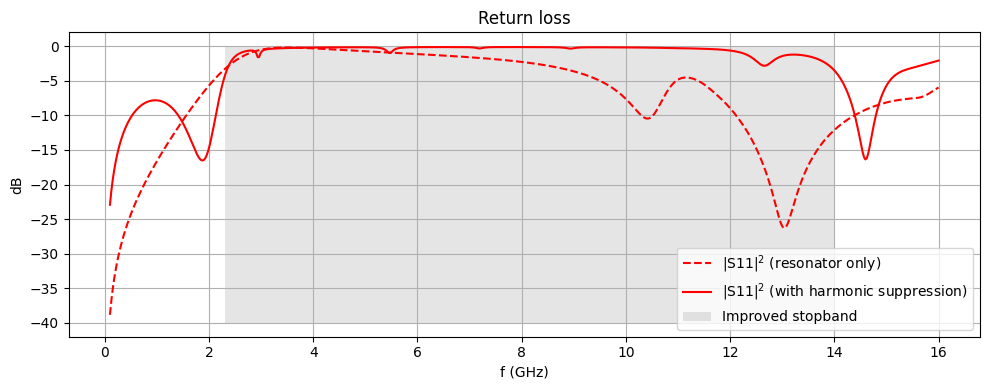

In [33]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, S11dB, "r--", label="|S11|$^2$ (resonator only)")
ax.plot(freqs / 1e9, S11dB_2, "r", label="|S11|$^2$ (with harmonic suppression)")
ax.add_patch(
    plt.Rectangle((2.3, 0), 14 - 2.3, -40, fc="gray", alpha=0.2, label="Improved stopband")
)
ax.set_title("Return loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

Below, we compare the insertion loss of the two structures. The operating frequency and its first 7 harmonics are indicated with black dotted lines. We find better signal rejection at all of the higher harmonics. 

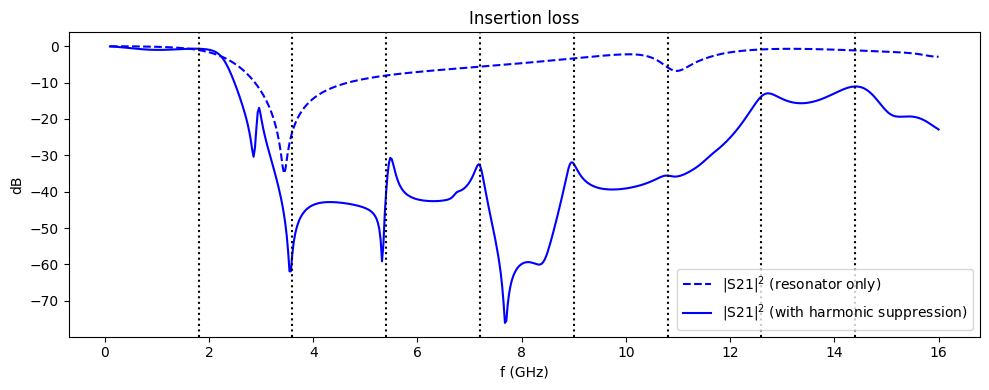

In [34]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, S21dB, "b--", label="|S21|$^2$ (resonator only)")
ax.plot(freqs / 1e9, S21dB_2, "b", label="|S21|$^2$ (with harmonic suppression)")
for f_plot in np.arange(1, 9) * 1.8:
    ax.axline((f_plot, -70), (f_plot, 0), ls=":", color="black")
ax.set_title("Insertion loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
plt.show()

#### Benchmark Comparison

For benchmarking purposes, we compare the computed S-parameters with results from an independent simulation run on a commercial FEM solver. We find excellent agreement.

In [35]:
freqs_ben, S11dB_ben, S21dB_ben = np.genfromtxt(
    "./misc/wpd-part2-fem.csv", delimiter=",", unpack=True
)

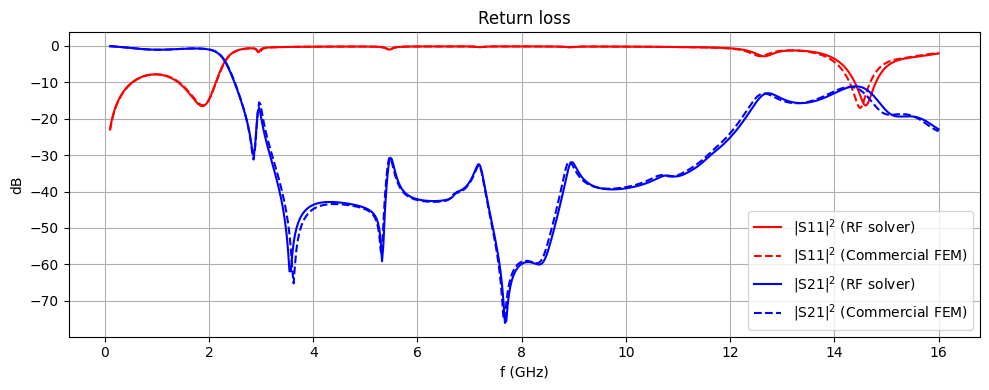

In [36]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, S11dB_2, "r", label="|S11|$^2$ (RF solver)")
ax.plot(freqs_ben, S11dB_ben, "r--", label="|S11|$^2$ (Commercial FEM)")
ax.plot(freqs / 1e9, S21dB_2, "b", label="|S21|$^2$ (RF solver)")
ax.plot(freqs_ben, S21dB_ben, "b--", label="|S21|$^2$ (Commercial FEM)")
ax.set_title("Return loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

## Conclusion

In this notebook, we investigated the addition of a harmonic suppression circuit to the previous low-pass filter design. This is shown to improve the stopband performance of the device up to the 7th harmonic. In the next notebook, we will simulate the full Wilkinson power divider using this structure as both branches of the divider. 
* [Designing a power divider for wireless communications part 1: Low-pass resonator](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression1/)
* [Designing a power divider for wireless communications part 3: Full divider structure](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression3/)

## Reference

[1] Moloudian, G., Soltani, S., Bahrami, S. et al. Design and fabrication of a Wilkinson power divider with harmonic suppression for LTE and GSM applications. Sci Rep 13, 4246 (2023). https://doi.org/10.1038/s41598-023-31019-7